# RCL Consensus Clustering Results

Visualization and validation of RCL multi-resolution consensus hierarchy on the 100 kbp NCBI_5 graph (133,724 nodes).  
Input: 14 clusterings (6 MCL + 8 Leiden). Resolutions 100–3200 (5 useful levels, res=6400 saturated).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from pathlib import Path

sns.set_style('darkgrid')

RCL_DIR = Path('Runs/RCL/consensus')
RESOLUTIONS = [100, 200, 400, 800, 1600, 3200]

# Load .info files (cluster metadata) and .txt files (node->cluster mapping)
info = {}   # res -> DataFrame
assign = {} # res -> dict {node_label: cluster_id}

for res in RESOLUTIONS:
    # Info file: tree, joinval, size, nesting, elements
    df = pd.read_csv(RCL_DIR / f'rcl.res{res}.info', sep = '\t',
                     usecols = ['tree', 'joinval', 'size', 'nesting'])
    info[res] = df

    # Assignment file: node_label \t cluster_id
    a = {}
    with open(RCL_DIR / f'rcl.res{res}.txt') as f:
        for line in f:
            label, cid = line.rstrip('\n').split('\t')
            a[label] = int(cid)
    assign[res] = a

# Load index -> label mapping
idx_to_label = {}
label_to_idx = {}
with open(RCL_DIR / 'rcl.tab') as f:
    for line in f:
        idx, label = line.rstrip('\n').split('\t')
        idx_to_label[int(idx)] = label
        label_to_idx[label] = int(idx)

n_nodes = len(idx_to_label)
print(f'Loaded {n_nodes:,} nodes')
print(f'Resolutions: {RESOLUTIONS}')
for res in RESOLUTIONS:
    print(f'  res={res}: {len(info[res]):,} clusters, {len(assign[res]):,} nodes assigned')

Loaded 133,724 nodes
Resolutions: [100, 200, 400, 800, 1600, 3200]
  res=100: 8,029 clusters, 133,724 nodes assigned
  res=200: 6,969 clusters, 133,724 nodes assigned
  res=400: 6,152 clusters, 133,724 nodes assigned
  res=800: 5,836 clusters, 133,724 nodes assigned
  res=1600: 5,714 clusters, 133,724 nodes assigned
  res=3200: 5,697 clusters, 133,724 nodes assigned


In [2]:
# Summary table
rows = []
for res in RESOLUTIONS:
    sizes = info[res]['size'].values
    rows.append({
        'Resolution': res,
        'Clusters': len(sizes),
        'Singletons': int((sizes == 1).sum()),
        'Min': int(sizes.min()),
        'Median': int(np.median(sizes)),
        'Mean': f'{sizes.mean():.1f}',
        'Max': int(sizes.max()),
        'Total nodes': int(sizes.sum()),
    })

summary = pd.DataFrame(rows)
summary

,Resolution,Clusters,Singletons,Min,Median,Mean,Max,Total nodes
0,100,8029,591,1,4,16.7,889,133724
1,200,6969,386,1,4,19.2,1134,133724
2,400,6152,142,1,4,21.7,1533,133724
3,800,5836,64,1,4,22.9,2520,133724
4,1600,5714,0,2,4,23.4,3503,133724
5,3200,5697,0,2,4,23.5,11872,133724


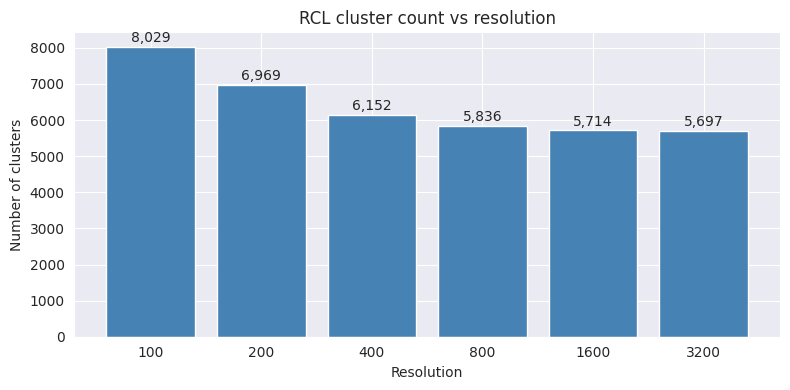

In [3]:
# Bar chart: cluster count vs resolution
fig, ax = plt.subplots(figsize = (8, 4))
counts = [len(info[r]) for r in RESOLUTIONS]
ax.bar([str(r) for r in RESOLUTIONS], counts, color = 'steelblue', edgecolor = 'white')
for i, c in enumerate(counts):
    ax.text(i, c + 50, f'{c:,}', ha = 'center', va = 'bottom', fontsize = 10)
ax.set_xlabel('Resolution')
ax.set_ylabel('Number of clusters')
ax.set_title('RCL cluster count vs resolution')
plt.tight_layout()
plt.show()

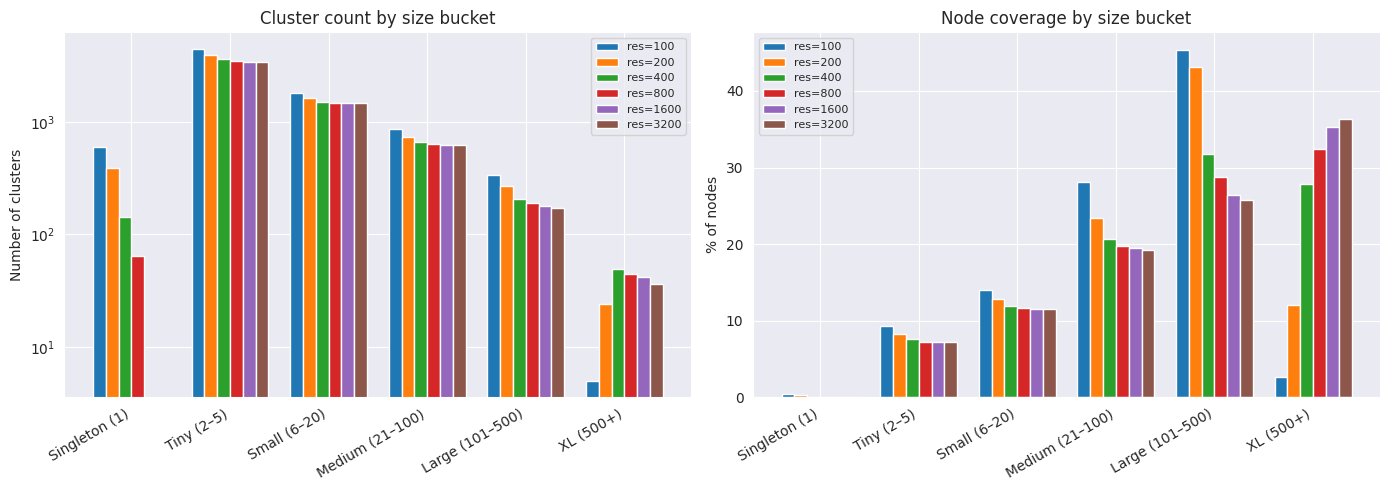

In [4]:
# Size distribution buckets
bucket_labels = ['Singleton (1)', 'Tiny (2\u20135)', 'Small (6\u201320)',
                 'Medium (21\u2013100)', 'Large (101\u2013500)', 'XL (500+)']
bucket_bounds = [(1, 1), (2, 5), (6, 20), (21, 100), (101, 500), (501, np.inf)]

# Count clusters and nodes in each bucket
cluster_counts = {res: [] for res in RESOLUTIONS}
node_fractions = {res: [] for res in RESOLUTIONS}

for res in RESOLUTIONS:
    sizes = info[res]['size'].values
    total = sizes.sum()
    for lo, hi in bucket_bounds:
        mask = (sizes >= lo) & (sizes <= hi)
        cluster_counts[res].append(mask.sum())
        node_fractions[res].append(sizes[mask].sum() / total)

fig, axes = plt.subplots(1, 2, figsize = (14, 5))

# By cluster count
x = np.arange(len(bucket_labels))
width = 0.13
for i, res in enumerate(RESOLUTIONS):
    axes[0].bar(x + i * width, cluster_counts[res], width,
                label = f'res={res}', edgecolor = 'white')
axes[0].set_xticks(x + width * 2.5)
axes[0].set_xticklabels(bucket_labels, rotation = 30, ha = 'right')
axes[0].set_ylabel('Number of clusters')
axes[0].set_title('Cluster count by size bucket')
axes[0].legend(fontsize = 8)
axes[0].set_yscale('log')

# By node fraction
for i, res in enumerate(RESOLUTIONS):
    axes[1].bar(x + i * width, [100 * f for f in node_fractions[res]], width,
                label = f'res={res}', edgecolor = 'white')
axes[1].set_xticks(x + width * 2.5)
axes[1].set_xticklabels(bucket_labels, rotation = 30, ha = 'right')
axes[1].set_ylabel('% of nodes')
axes[1].set_title('Node coverage by size bucket')
axes[1].legend(fontsize = 8)

plt.tight_layout()
plt.show()

## Section 2: Cluster size distributions

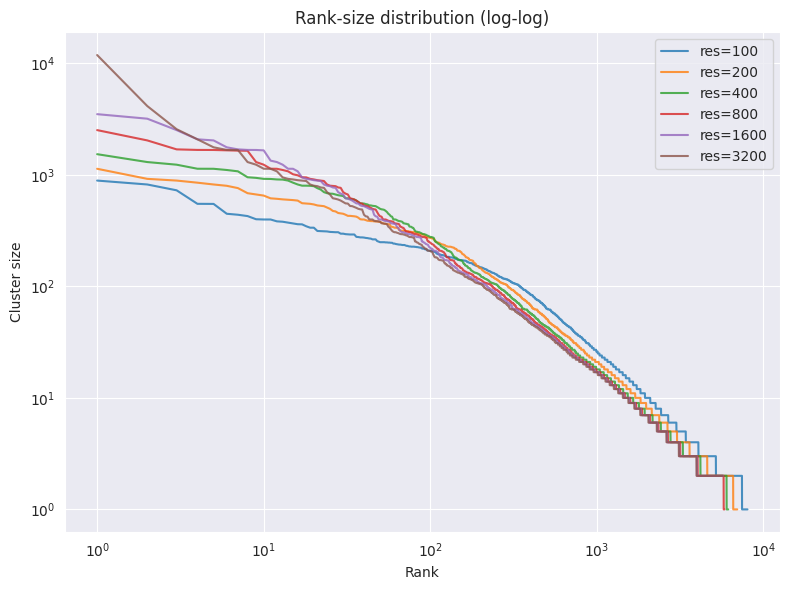

In [5]:
# Log-log rank-size plot (power-law check)
fig, ax = plt.subplots(figsize = (8, 6))

for res in RESOLUTIONS:
    sizes = np.sort(info[res]['size'].values)[::-1]  # descending
    ranks = np.arange(1, len(sizes) + 1)
    ax.plot(ranks, sizes, label = f'res={res}', alpha = 0.8)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Rank')
ax.set_ylabel('Cluster size')
ax.set_title('Rank-size distribution (log-log)')
ax.legend()
plt.tight_layout()
plt.show()

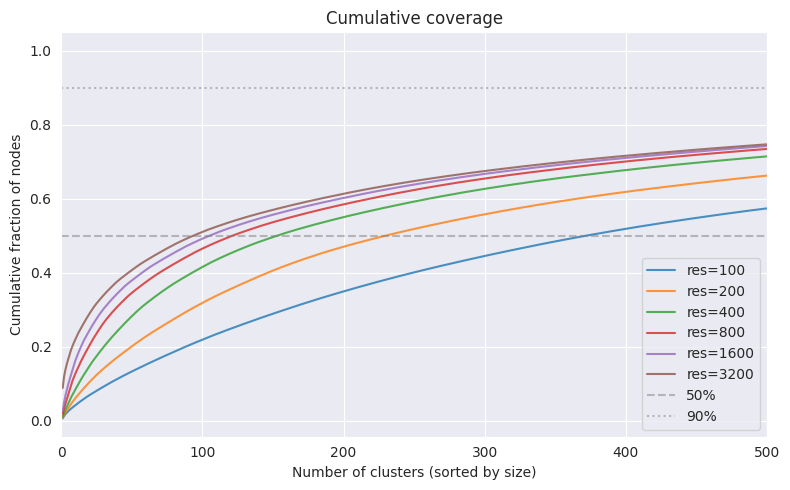

res=100: 372 clusters for 50%, 2,963 clusters for 90%
res=200: 230 clusters for 50%, 2,348 clusters for 90%
res=400: 153 clusters for 50%, 1,945 clusters for 90%
res=800: 122 clusters for 50%, 1,799 clusters for 90%
res=1600: 105 clusters for 50%, 1,749 clusters for 90%
res=3200: 94 clusters for 50%, 1,732 clusters for 90%


In [6]:
# Cumulative coverage: fraction of nodes vs number of clusters (sorted largest-first)
fig, ax = plt.subplots(figsize = (8, 5))

for res in RESOLUTIONS:
    sizes = np.sort(info[res]['size'].values)[::-1]
    cumfrac = np.cumsum(sizes) / sizes.sum()
    ax.plot(np.arange(1, len(sizes) + 1), cumfrac, label = f'res={res}', alpha = 0.8)

ax.set_xlabel('Number of clusters (sorted by size)')
ax.set_ylabel('Cumulative fraction of nodes')
ax.set_title('Cumulative coverage')
ax.axhline(0.5, color = 'gray', linestyle = '--', alpha = 0.5, label = '50%')
ax.axhline(0.9, color = 'gray', linestyle = ':', alpha = 0.5, label = '90%')
ax.set_xlim(0, 500)
ax.legend()
plt.tight_layout()
plt.show()

# Print how many clusters needed for 50% and 90% coverage
for res in RESOLUTIONS:
    sizes = np.sort(info[res]['size'].values)[::-1]
    cumfrac = np.cumsum(sizes) / sizes.sum()
    n50 = np.searchsorted(cumfrac, 0.5) + 1
    n90 = np.searchsorted(cumfrac, 0.9) + 1
    print(f'res={res}: {n50:,} clusters for 50%, {n90:,} clusters for 90%')

## Section 3: Nesting visualization

In [7]:
# Parse element sets from .info files for nesting analysis
# We load element indices (graph node indices) per cluster per resolution
elements = {}  # res -> list of sets of node indices

for res in RESOLUTIONS:
    df_full = pd.read_csv(RCL_DIR / f'rcl.res{res}.info', sep = '\t')
    cluster_sets = []
    for _, row in df_full.iterrows():
        elems = set(int(x) for x in row['elements'].split())
        cluster_sets.append(elems)
    elements[res] = cluster_sets

print('Element sets loaded per resolution:')
for res in RESOLUTIONS:
    total = sum(len(s) for s in elements[res])
    print(f'  res={res}: {len(elements[res]):,} clusters, {total:,} total elements')

Element sets loaded per resolution:
  res=100: 8,029 clusters, 133,724 total elements
  res=200: 6,969 clusters, 133,724 total elements
  res=400: 6,152 clusters, 133,724 total elements
  res=800: 5,836 clusters, 133,724 total elements
  res=1600: 5,714 clusters, 133,724 total elements
  res=3200: 5,697 clusters, 133,724 total elements


In [8]:
# Track top 10 largest clusters at res=3200 through finer resolutions
top_n = 10
coarsest = 3200
top_indices = np.argsort(-info[coarsest]['size'].values)[:top_n]

print(f'Top {top_n} clusters at res={coarsest}:')
for i, idx in enumerate(top_indices):
    row = info[coarsest].iloc[idx]
    print(f'  #{i + 1}: {row["tree"]} (size={row["size"]:,}, nesting={row["nesting"]})')

# For each top cluster at res=3200, find children at each finer resolution
# A child at res_fine is a cluster whose element set is a subset of the parent
lineages = {}  # parent_idx -> {res: [child_indices]}

for pidx in top_indices:
    parent_set = elements[coarsest][pidx]
    lineages[pidx] = {coarsest: [pidx]}

    for res in sorted([r for r in RESOLUTIONS if r < coarsest], reverse = True):
        children = []
        for cidx, cset in enumerate(elements[res]):
            if cset.issubset(parent_set):
                children.append(cidx)
        lineages[pidx][res] = children

# Summary: how top clusters fragment
print(f'\nFragmentation of top {top_n} clusters from res={coarsest}:')
print(f'{"Cluster":>20s}', end = '')
for res in sorted(RESOLUTIONS):
    print(f'  res={res:>4d}', end = '')
print()

for pidx in top_indices:
    label = info[coarsest].iloc[pidx]['tree']
    size = info[coarsest].iloc[pidx]['size']
    print(f'{label:>20s}', end = '')
    for res in sorted(RESOLUTIONS):
        n_children = len(lineages[pidx].get(res, []))
        print(f'  {n_children:>9d}', end = '')
    print(f'  (size={size:,})')

Top 10 clusters at res=3200:
  #1: L128025_11872 (size=11,872, nesting=B)
  #2: L128017_4141 (size=4,141, nesting=C)
  #3: L127927_2567 (size=2,567, nesting=D)
  #4: L128027_2084 (size=2,084, nesting=E)
  #5: L128022_1767 (size=1,767, nesting=F)
  #6: L127990_1674 (size=1,674, nesting=G)
  #7: L127960_1672 (size=1,672, nesting=H)
  #8: L128003_1303 (size=1,303, nesting=I)
  #9: L128026_1234 (size=1,234, nesting=J)
  #10: L128010_1135 (size=1,135, nesting=K)

Fragmentation of top 10 clusters from res=3200:
             Cluster  res= 100  res= 200  res= 400  res= 800  res=1600  res=3200
       L128025_11872        390        269        190        130         12          1  (size=11,872)
        L128017_4141         64         35         16          6          6          1  (size=4,141)
        L127927_2567        404        400        123          2          2          1  (size=2,567)
        L128027_2084         18         11          6          3          1          1  (size=2,084)
   

In [9]:
# Sankey diagram: show how top 5 clusters at res=3200 fragment across resolutions
import plotly.graph_objects as go

# Use 4 resolution levels for readability
sankey_resolutions = [3200, 800, 200, 100]
top_sankey = 5

# Build nodes and links
node_labels = []
node_colors = []
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

def hex_to_rgba(hex_color, alpha = 0.25):
    r, g, b = int(hex_color[1:3], 16), int(hex_color[3:5], 16), int(hex_color[5:7], 16)
    return f'rgba({r},{g},{b},{alpha})'

# Maps: (parent_rank, res, cluster_idx_or_'rest') -> sankey_node_id
sankey_id = {}
links_source = []
links_target = []
links_value = []
links_color = []

for parent_rank, pidx in enumerate(top_indices[:top_sankey]):
    color = palette[parent_rank]
    light_color = hex_to_rgba(color)  # semi-transparent for links

    for res in sankey_resolutions:
        children = lineages[pidx].get(res, [])
        # Sort by size descending, keep top children + bundle rest
        child_sizes = [(c, info[res].iloc[c]['size']) for c in children]
        child_sizes.sort(key = lambda x: -x[1])

        max_show = 5 if res != 3200 else 1
        shown = child_sizes[:max_show]
        bundled = child_sizes[max_show:]

        for cidx, csize in shown:
            sid = len(node_labels)
            sankey_id[(parent_rank, res, cidx)] = sid
            if res == 3200:
                node_labels.append(f'res={res} #{parent_rank + 1} (n={csize:,})')
            else:
                node_labels.append(f'{csize:,}')
            node_colors.append(color)

        if bundled:
            sid = len(node_labels)
            bundled_size = sum(s for _, s in bundled)
            sankey_id[(parent_rank, res, 'rest')] = sid
            node_labels.append(f'{len(bundled)} small ({bundled_size:,})')
            node_colors.append(color)

    # Create links between adjacent resolution levels
    for i in range(len(sankey_resolutions) - 1):
        res_coarse = sankey_resolutions[i]
        res_fine = sankey_resolutions[i + 1]

        # Get coarse-level nodes for this parent
        coarse_children = lineages[pidx].get(res_coarse, [])
        coarse_sizes = [(c, info[res_coarse].iloc[c]['size']) for c in coarse_children]
        coarse_sizes.sort(key = lambda x: -x[1])

        max_coarse = 5 if res_coarse != 3200 else 1
        coarse_shown = coarse_sizes[:max_coarse]
        coarse_rest = coarse_sizes[max_coarse:]

        fine_children = lineages[pidx].get(res_fine, [])
        fine_sizes_list = [(c, info[res_fine].iloc[c]['size']) for c in fine_children]
        fine_sizes_list.sort(key = lambda x: -x[1])

        max_fine = 5
        fine_shown = fine_sizes_list[:max_fine]
        fine_rest = fine_sizes_list[max_fine:]

        # For each coarse node, find which fine nodes are its children
        for cidx_c, csize_c in coarse_shown:
            cset_c = elements[res_coarse][cidx_c]
            src = sankey_id[(parent_rank, res_coarse, cidx_c)]

            for cidx_f, csize_f in fine_shown:
                cset_f = elements[res_fine][cidx_f]
                if cset_f.issubset(cset_c):
                    tgt = sankey_id[(parent_rank, res_fine, cidx_f)]
                    links_source.append(src)
                    links_target.append(tgt)
                    links_value.append(csize_f)
                    links_color.append(light_color)

            # Bundle rest
            rest_size = 0
            for cidx_f, csize_f in fine_rest:
                cset_f = elements[res_fine][cidx_f]
                if cset_f.issubset(cset_c):
                    rest_size += csize_f
            if rest_size > 0 and (parent_rank, res_fine, 'rest') in sankey_id:
                tgt = sankey_id[(parent_rank, res_fine, 'rest')]
                links_source.append(src)
                links_target.append(tgt)
                links_value.append(rest_size)
                links_color.append(light_color)

        # Links from coarse rest -> fine nodes
        if coarse_rest and (parent_rank, res_coarse, 'rest') in sankey_id:
            src = sankey_id[(parent_rank, res_coarse, 'rest')]
            rest_coarse_set = set()
            for cidx_c, _ in coarse_rest:
                rest_coarse_set.update(elements[res_coarse][cidx_c])

            for cidx_f, csize_f in fine_shown:
                cset_f = elements[res_fine][cidx_f]
                if cset_f.issubset(rest_coarse_set):
                    tgt = sankey_id[(parent_rank, res_fine, cidx_f)]
                    links_source.append(src)
                    links_target.append(tgt)
                    links_value.append(csize_f)
                    links_color.append(light_color)

            rest_fine_size = 0
            for cidx_f, csize_f in fine_rest:
                cset_f = elements[res_fine][cidx_f]
                if cset_f.issubset(rest_coarse_set):
                    rest_fine_size += csize_f
            if rest_fine_size > 0 and (parent_rank, res_fine, 'rest') in sankey_id:
                tgt = sankey_id[(parent_rank, res_fine, 'rest')]
                links_source.append(src)
                links_target.append(tgt)
                links_value.append(rest_fine_size)
                links_color.append(light_color)

fig = go.Figure(data = [go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        label = node_labels,
        color = node_colors,
    ),
    link = dict(
        source = links_source,
        target = links_target,
        value = links_value,
        color = links_color,
    )
)])

fig.update_layout(
    title_text = f'Cluster nesting: top {top_sankey} clusters at res=3200 \u2192 res=100',
    font_size = 11,
    width = 1000,
    height = 600,
)
fig.show()

## Section 4: GC span validation

In [10]:
# Load IDs and k-mers for 100 kbp sequences
MIN_LENGTH = 100_000

all_ids = np.loadtxt('Runs/ids_SFE_SE_1.txt', dtype = str)
kmers_mmap = np.load('Runs/kmers_SFE_SE_1.npy', mmap_mode = 'r')
all_lengths = kmers_mmap[:, 0]
long_mask = all_lengths >= MIN_LENGTH

print(f'Total sequences: {len(all_lengths):,}')
print(f'Sequences >= {MIN_LENGTH:,} bp: {long_mask.sum():,}')

long_ids = all_ids[long_mask]
# GC content = last column of k-mers (1-mer G+C frequency)
gc_all = np.array(kmers_mmap[long_mask, -1])  # copy from mmap

# Build mapping: sequence label -> index in filtered arrays
id_to_filtered_idx = {label: i for i, label in enumerate(long_ids)}

print(f'GC range: {gc_all.min():.3f} - {gc_all.max():.3f}')
print(f'GC mean: {gc_all.mean():.3f}')

del all_ids, all_lengths

Total sequences: 6,693,829
Sequences >= 100,000 bp: 154,040
GC range: 0.141 - 0.829
GC mean: 0.477


In [11]:
# Map RCL cluster assignments to filtered sequence indices

def get_cluster_members(res, min_size = 1):
    """Return dict: cluster_id -> array of filtered indices."""
    clusters = {}
    for label, cid in assign[res].items():
        if label in id_to_filtered_idx:
            clusters.setdefault(cid, []).append(id_to_filtered_idx[label])
    return {cid: np.array(idxs) for cid, idxs in clusters.items()
            if len(idxs) >= min_size}


# Check mapping coverage
members_100 = get_cluster_members(100)
total_mapped = sum(len(v) for v in members_100.values())
print(f'Mapped {total_mapped:,} / {n_nodes:,} graph nodes to filtered sequences')
print(f'Unique clusters at res=100: {len(members_100):,}')

Mapped 133,724 / 133,724 graph nodes to filtered sequences
Unique clusters at res=100: 8,029


In [12]:
# GC span for top N clusters at res=100
def gc_stats(cluster_indices):
    """Compute GC statistics for a cluster."""
    gc = gc_all[cluster_indices]
    return {
        'size': len(cluster_indices),
        'gc_mean': 100 * gc.mean(),
        'gc_std': 100 * gc.std(),
        'gc_min': 100 * gc.min(),
        'gc_max': 100 * gc.max(),
        'gc_span': 100 * (gc.max() - gc.min()),
    }


def top_cluster_table(res, n_top = 20):
    """Build GC stats table for top n clusters at given resolution."""
    members = get_cluster_members(res, min_size = 2)
    sorted_cids = sorted(members.keys(), key = lambda c: -len(members[c]))

    rows = []
    for rank, cid in enumerate(sorted_cids[:n_top]):
        stats = gc_stats(members[cid])
        rows.append({
            'Rank': rank + 1,
            'Cluster': cid,
            'Size': stats['size'],
            'GC mean (%)': f'{stats["gc_mean"]:.1f}',
            'GC std (%)': f'{stats["gc_std"]:.1f}',
            'GC span (pp)': f'{stats["gc_span"]:.1f}',
            'GC range': f'{stats["gc_min"]:.1f}\u2013{stats["gc_max"]:.1f}%',
        })
    return pd.DataFrame(rows)


print('Top 20 clusters at res=100 (finest):')
table_100 = top_cluster_table(100, 20)
table_100

Top 20 clusters at res=100 (finest):


,Rank,Cluster,Size,GC mean (%),GC std (%),GC span (pp),GC range
0,1,0,889,54.8,0.8,6.1,51.1–57.2%
1,2,1,820,60.2,1.6,11.7,52.9–64.6%
2,3,2,727,49.4,1.8,10.8,43.0–53.9%
3,4,3,550,36.8,1.6,10.6,33.1–43.6%
4,5,4,549,39.3,0.9,6.8,36.4–43.2%
5,6,5,448,53.0,3.1,19.1,44.6–63.6%
6,7,6,439,56.6,0.9,8.5,50.5–59.0%
7,8,7,427,44.3,0.5,4.1,41.6–45.7%
8,9,8,400,59.2,2.2,11.3,54.0–65.3%
9,10,10,398,47.0,4.2,20.1,40.5–60.6%


In [13]:
# GC span for top clusters at res=800
print('Top 20 clusters at res=800:')
table_800 = top_cluster_table(800, 20)
table_800

Top 20 clusters at res=800:


,Rank,Cluster,Size,GC mean (%),GC std (%),GC span (pp),GC range
0,1,0,2520,61.6,3.5,16.5,55.0–71.5%
1,2,1,2037,35.1,3.9,15.6,26.6–42.1%
2,3,2,1693,34.1,3.0,15.4,28.2–43.6%
3,4,3,1674,47.7,1.5,10.2,41.5–51.7%
4,5,4,1672,43.8,3.3,19.6,35.3–54.8%
5,6,5,1659,39.9,6.4,24.7,28.5–53.2%
6,7,6,1650,61.1,2.8,21.3,46.1–67.4%
7,8,7,1644,38.2,3.6,20.1,29.0–49.1%
8,9,8,1303,49.7,2.3,17.0,42.0–59.1%
9,10,9,1234,55.8,2.2,15.2,47.6–62.9%


In [14]:
# Compare against MCL I=3.0 baseline
mcl_dir = 'Runs/MCL_100_NCBI_5_d5'
mcl_file = f'{mcl_dir}/mcl_I3.0.clusters'

mcl_clusters = []
with open(mcl_file) as f:
    for line in f:
        members_list = line.rstrip('\n').split('\t')
        if len(members_list) > 1:
            indices = [id_to_filtered_idx[m] for m in members_list
                       if m in id_to_filtered_idx]
            if len(indices) > 1:
                mcl_clusters.append(np.array(indices))

mcl_clusters.sort(key = len, reverse = True)
print(f'MCL I=3.0: {len(mcl_clusters):,} non-singleton clusters')
print(f'Top 5 sizes: {[len(c) for c in mcl_clusters[:5]]}')
print()

# GC stats for MCL top clusters
rows = []
for rank in range(min(20, len(mcl_clusters))):
    stats = gc_stats(mcl_clusters[rank])
    rows.append({
        'Rank': rank + 1,
        'Size': stats['size'],
        'GC mean (%)': f'{stats["gc_mean"]:.1f}',
        'GC span (pp)': f'{stats["gc_span"]:.1f}',
        'GC range': f'{stats["gc_min"]:.1f}\u2013{stats["gc_max"]:.1f}%',
    })

mcl_table = pd.DataFrame(rows)
print('MCL I=3.0 baseline (top 20):')
mcl_table

MCL I=3.0: 11,413 non-singleton clusters
Top 5 sizes: [180, 170, 168, 164, 159]

MCL I=3.0 baseline (top 20):


,Rank,Size,GC mean (%),GC span (pp),GC range
0,1,180,52.7,3.9,51.2–55.1%
1,2,170,57.7,4.0,55.7–59.7%
2,3,168,56.9,3.5,55.2–58.7%
3,4,164,46.7,4.5,44.1–48.6%
4,5,159,50.4,4.0,49.0–53.0%
5,6,158,52.6,7.9,48.2–56.1%
6,7,158,62.7,4.4,60.4–64.8%
7,8,158,37.9,5.4,34.9–40.2%
8,9,157,43.3,6.2,40.7–46.9%
9,10,156,51.6,5.2,49.0–54.2%


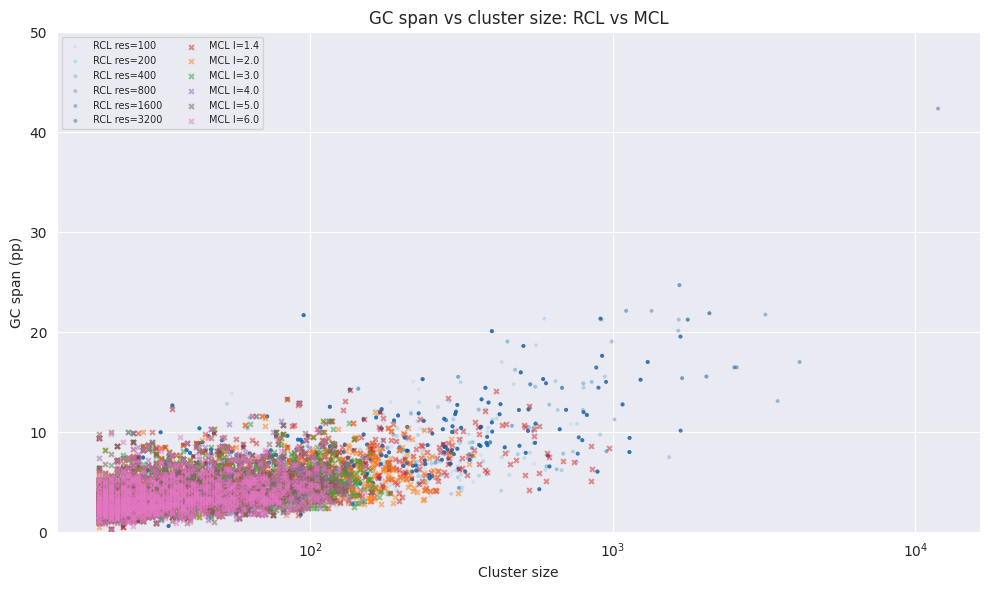

In [15]:
# GC span vs cluster size: RCL (all resolutions) vs MCL (all inflations)
# Fair size-matched comparison

fig, ax = plt.subplots(figsize = (10, 6))

# RCL: all clusters >= 20 nodes at each resolution
rcl_colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(RESOLUTIONS)))
for i, res in enumerate(RESOLUTIONS):
    members = get_cluster_members(res, min_size = 20)
    sizes_list = []
    spans_list = []
    for cid, idxs in members.items():
        gc = gc_all[idxs]
        sizes_list.append(len(idxs))
        spans_list.append(100 * (gc.max() - gc.min()))
    ax.scatter(sizes_list, spans_list, s = 8, alpha = 0.4, color = rcl_colors[i],
               label = f'RCL res={res}', edgecolors = 'none')

# MCL: all inflations, clusters >= 20 nodes
mcl_colors = {'1.4': '#d62728', '2.0': '#ff7f0e', '3.0': '#2ca02c',
              '4.0': '#9467bd', '5.0': '#8c564b', '6.0': '#e377c2'}
for infl_str, color in mcl_colors.items():
    mcl_file = f'Runs/MCL_100_NCBI_5_d5/mcl_I{infl_str}.clusters'
    sizes_list = []
    spans_list = []
    with open(mcl_file) as f:
        for line in f:
            members_list = line.rstrip('\n').split('\t')
            indices = [id_to_filtered_idx[m] for m in members_list
                       if m in id_to_filtered_idx]
            if len(indices) >= 20:
                gc = gc_all[np.array(indices)]
                sizes_list.append(len(indices))
                spans_list.append(100 * (gc.max() - gc.min()))
    ax.scatter(sizes_list, spans_list, s = 12, alpha = 0.5, color = color,
               label = f'MCL I={infl_str}', marker = 'x')

ax.set_xlabel('Cluster size')
ax.set_ylabel('GC span (pp)')
ax.set_title('GC span vs cluster size: RCL vs MCL')
ax.set_xscale('log')
ax.legend(fontsize = 7, ncol = 2, loc = 'upper left')
ax.set_ylim(0, 50)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1454218/2798971563.py:37: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



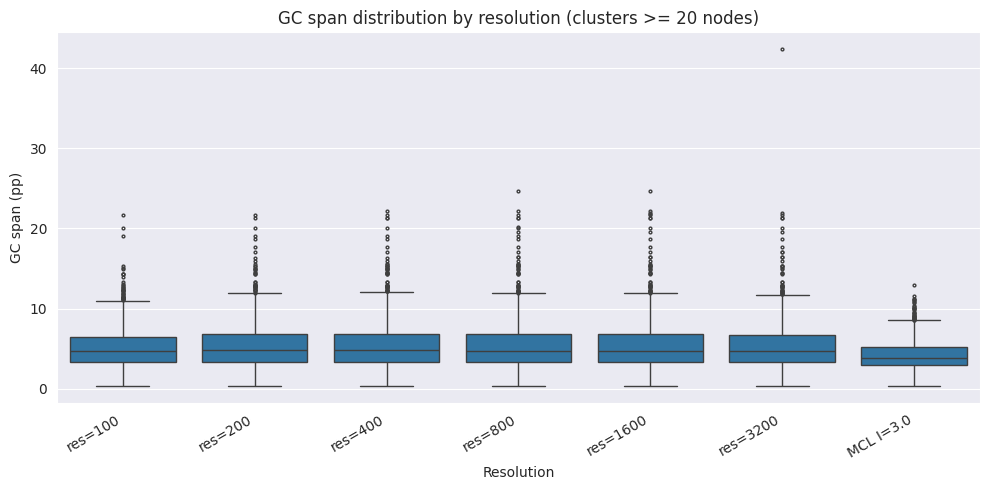

Method        N clusters    Median      Mean       P25       P75
res=100            1,254       4.7       5.2       3.4       6.4
res=200            1,064       4.8       5.4       3.4       6.8
res=400              949       4.8       5.6       3.4       6.8
res=800              903       4.8       5.5       3.3       6.8
res=1600             881       4.7       5.5       3.3       6.8
res=3200             864       4.7       5.4       3.3       6.7
MCL I=3.0          1,650       3.9       4.2       2.9       5.2


In [16]:
# GC span distributions across resolutions (clusters >= 20 nodes)
MIN_CLUSTER = 20

box_data = []
for res in RESOLUTIONS:
    members = get_cluster_members(res, min_size = MIN_CLUSTER)
    for cid, idxs in members.items():
        gc = gc_all[idxs]
        box_data.append({
            'Resolution': f'res={res}',
            'GC span (pp)': 100 * (gc.max() - gc.min()),
            'size': len(idxs),
        })

# Add MCL I=3.0 for comparison
mcl_file = 'Runs/MCL_100_NCBI_5_d5/mcl_I3.0.clusters'
with open(mcl_file) as f:
    for line in f:
        members_list = line.rstrip('\n').split('\t')
        indices = [id_to_filtered_idx[m] for m in members_list
                   if m in id_to_filtered_idx]
        if len(indices) >= MIN_CLUSTER:
            gc = gc_all[np.array(indices)]
            box_data.append({
                'Resolution': 'MCL I=3.0',
                'GC span (pp)': 100 * (gc.max() - gc.min()),
                'size': len(indices),
            })

box_df = pd.DataFrame(box_data)

fig, ax = plt.subplots(figsize = (10, 5))
order = [f'res={r}' for r in RESOLUTIONS] + ['MCL I=3.0']
sns.boxplot(data = box_df, x = 'Resolution', y = 'GC span (pp)',
            order = order, ax = ax, fliersize = 2)
ax.set_title(f'GC span distribution by resolution (clusters >= {MIN_CLUSTER} nodes)')
ax.set_xticklabels(order, rotation = 30, ha = 'right')
plt.tight_layout()
plt.show()

# Print summary stats
print(f'{"Method":<12s}  {"N clusters":>10s}  {"Median":>8s}  {"Mean":>8s}  {"P25":>8s}  {"P75":>8s}')
for label in order:
    sub = box_df[box_df['Resolution'] == label]['GC span (pp)']
    print(f'{label:<12s}  {len(sub):>10,}  {sub.median():>8.1f}  {sub.mean():>8.1f}  '
          f'{sub.quantile(0.25):>8.1f}  {sub.quantile(0.75):>8.1f}')

## Section 5: GC span vs resolution trajectory

In [17]:
# Per-child GC span statistics at each resolution
# For each lineage, compute GC span of each *individual* child cluster,
# then report median, max, and size-weighted mean across children

n_lineages = 5
child_gc_stats = {}  # pidx -> {res: {median_span, max_span, weighted_span, largest_span, n_children}}

for pidx in top_indices[:n_lineages]:
    child_gc_stats[pidx] = {}

    for res in RESOLUTIONS:
        children = lineages[pidx].get(res, [])
        if not children:
            continue

        spans = []
        sizes = []
        for cidx in children:
            # Map element indices to filtered sequence indices
            child_idxs = []
            for node_idx in elements[res][cidx]:
                label = idx_to_label.get(node_idx)
                if label and label in id_to_filtered_idx:
                    child_idxs.append(id_to_filtered_idx[label])
            if len(child_idxs) >= 2:
                gc = gc_all[np.array(child_idxs)]
                spans.append(100 * (gc.max() - gc.min()))
                sizes.append(len(child_idxs))

        if spans:
            spans = np.array(spans)
            sizes = np.array(sizes)
            largest_idx = np.argmax(sizes)
            child_gc_stats[pidx][res] = {
                'median_span': np.median(spans),
                'max_span': spans.max(),
                'weighted_span': np.average(spans, weights = sizes),
                'largest_span': spans[largest_idx],
                'largest_size': sizes[largest_idx],
                'n_children': len(spans),
                'total_nodes': sizes.sum(),
            }

# Print trajectory data
for pidx in top_indices[:n_lineages]:
    label = info[coarsest].iloc[pidx]['tree']
    size = info[coarsest].iloc[pidx]['size']
    print(f'\n{label} (size={size:,}):')
    print(f'  {"res":>6s}  {"#cls":>5s}  {"nodes":>7s}  {"largest":>8s}  '
          f'{"lrg span":>8s}  {"median":>7s}  {"wtd mean":>8s}  {"max":>7s}')
    for res in RESOLUTIONS:
        if res in child_gc_stats[pidx]:
            s = child_gc_stats[pidx][res]
            print(f'  {res:>6d}  {s["n_children"]:>5d}  {s["total_nodes"]:>7,}  '
                  f'{s["largest_size"]:>8,}  {s["largest_span"]:>7.1f}pp  '
                  f'{s["median_span"]:>6.1f}pp  {s["weighted_span"]:>7.1f}pp  '
                  f'{s["max_span"]:>6.1f}pp')


L128025_11872 (size=11,872):
     res   #cls    nodes   largest  lrg span   median  wtd mean      max
     100    226   11,708       448     19.1pp     2.0pp      7.1pp    19.1pp
     200    145   11,748       616     12.8pp     2.1pp      9.1pp    19.1pp
     400     95   11,777     1,106     22.1pp     2.5pp     11.0pp    22.1pp
     800     66   11,808     1,659     24.7pp     2.5pp     13.6pp    24.7pp
    1600     12   11,872     3,503     13.1pp    12.2pp     17.9pp    24.7pp
    3200      1   11,872    11,872     42.4pp    42.4pp     42.4pp    42.4pp

L128017_4141 (size=4,141):
     res   #cls    nodes   largest  lrg span   median  wtd mean      max
     100     63    4,140       373      7.1pp     3.1pp      6.1pp    11.9pp
     200     35    4,141       528     10.5pp     4.7pp      7.5pp    11.9pp
     400     16    4,141       940     15.6pp     6.8pp     10.3pp    15.6pp
     800      6    4,141     2,037     15.6pp     8.0pp     14.7pp    15.6pp
    1600      6    4,141  

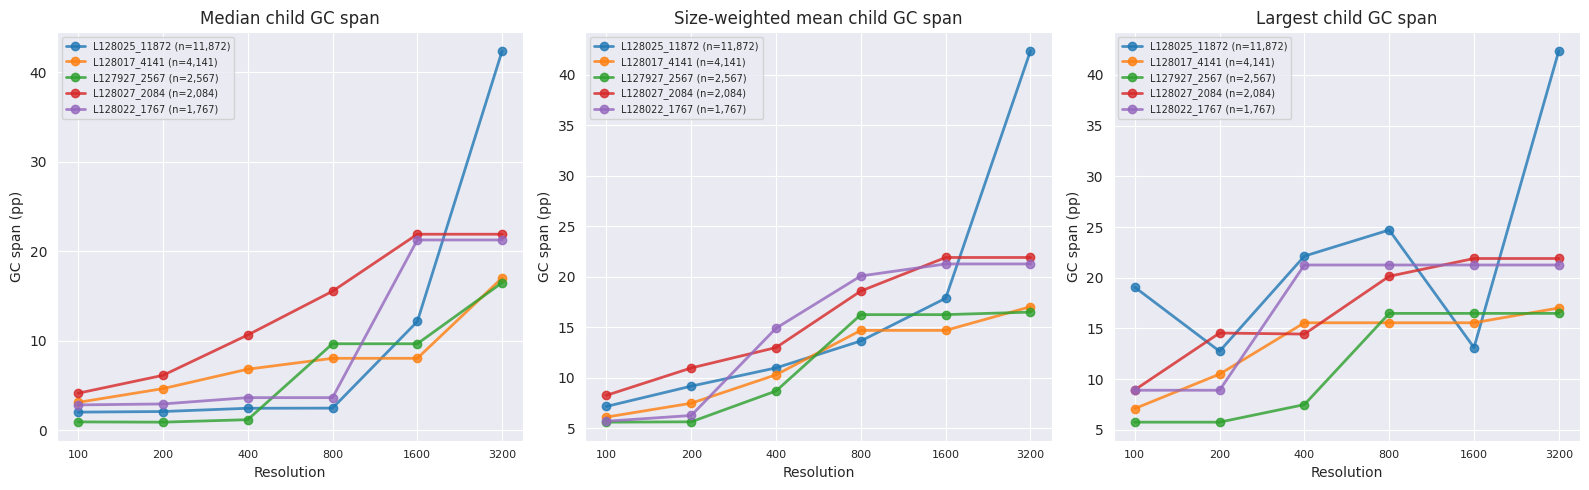

In [18]:
# Line plot: per-child GC span metrics vs resolution
fig, axes = plt.subplots(1, 3, figsize = (16, 5))

for i, pidx in enumerate(top_indices[:n_lineages]):
    label = info[coarsest].iloc[pidx]['tree']
    size = info[coarsest].iloc[pidx]['size']
    resolutions = sorted(child_gc_stats[pidx].keys())
    
    median_spans = [child_gc_stats[pidx][r]['median_span'] for r in resolutions]
    weighted_spans = [child_gc_stats[pidx][r]['weighted_span'] for r in resolutions]
    largest_spans = [child_gc_stats[pidx][r]['largest_span'] for r in resolutions]

    axes[0].plot(resolutions, median_spans, 'o-', label = f'{label} (n={size:,})',
                 alpha = 0.8, linewidth = 2)
    axes[1].plot(resolutions, weighted_spans, 'o-', label = f'{label} (n={size:,})',
                 alpha = 0.8, linewidth = 2)
    axes[2].plot(resolutions, largest_spans, 'o-', label = f'{label} (n={size:,})',
                 alpha = 0.8, linewidth = 2)

titles = ['Median child GC span', 'Size-weighted mean child GC span',
          'Largest child GC span']
for j, ax in enumerate(axes):
    ax.set_xlabel('Resolution')
    ax.set_ylabel('GC span (pp)')
    ax.set_title(titles[j])
    ax.legend(fontsize = 7)
    ax.set_xscale('log', base = 2)
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xticks(RESOLUTIONS)
    ax.tick_params(axis = 'x', labelsize = 8)

plt.tight_layout()
plt.show()